# RV calculation at Observation Times.

To determine the expected RV shifts of the spectral lines seen my stellar subracted spectra.

## Update: August 2017
I had a huge problem with my RV of my observations.
It turns I was using jd (with 24000000) but the tau parameter is in reduced jd (without 2400000)
Changes phase of positions alot.

In [42]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

from PyAstronomy import pyasl   # for doppler shift
import sys
#sys.path.append('/home/jneal/azores/planet/rvs/exonailer/utilities')

from observationtools import RV
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [43]:
#Rodrigo Diaz's true anomaly calculation
def trueanomaly(ma, ecc, niterationmax=10000):
    """
    Compute the true anomaly using the Newton-Raphson method.

    :param array-like ma: mean anomaly.
    :param float ecc: orbital eccentricity.
    :param int niterationmax: maximum number of iterations for N-R method.
    """
    
    if not isinstance(ma, float):
        ea = ma
    else:
        ea = np.array([ma,])

    # Initialise at ea0 = ma
    niteration = 0
    ea0 = ma
    
    while np.linalg.norm(ea - ea0, ord=1) > 1e-5 or niteration==0:
        ea0 = ea
 
        ff = ea - ecc*np.sin(ea) - ma   # Function
        dff = 1 - ecc*np.cos(ea)        # Derivative

        # Use Newton method
        ea = ea0 - ff / dff

        # Increase iteration number; if above limit, break with exception.
        niteration += 1
        if niteration >= niterationmax:
            raise RuntimeError('Eccentric anomaly computation'
                               'not converged.')
        
    # Compute true anomaly from eccentric anomaly
    return 2. * np.arctan2(np.sqrt(1. + ecc) * np.sin(ea/2.),
                           np.sqrt(1. - ecc) * np.cos(ea/2.))

# Mean Anomaly calculation
def meananomaly(t, T0, P):
    """ Calculate mean Anomaly using period, tau and a time value"""
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    return 2 * np.pi * (t - T0) / P

# Basic RV calculation
def radialvelocity(gamma, K, ta, omega, ecc):
    # Calculate radial velocity of star
    return gamma + K *(np.cos(ta + omega) + ecc * np.cos(omega))

# RV calculation done in python (for when ajplanet is not available)
def rv_curve_py(t, gamma, K, omega, ecc, T, P):
    ma = meananomaly(t, T, P)
    ta = trueanomaly(ma, ecc)
    rv = radialvelocity(gamma, K, ta, omega, ecc)
    return rv
        

In [44]:
#Silly epoch of T0 in a paper of 1997.04 +- 0.02 . need to turn into julian days
#Crepp 2016 updated HD4747 parameters  t = 1997.04
#print(0.04 * 365)
#print(.6*24)
#print(.4*60)
# Julian date for CE  1997 January 14 14:24:00.0 UT is JD 2450463.100000

# Orbtial Parameters and epochs.

In [67]:
Msun_Mjup = 1047.56 # Mjup

#Target parameters:  Obtained from sahlmann et al. 

#HD4747_params   = [9.904, 703.3, -94.2, 0.723, 62059.1, 11593.2] # Best fit solution from sahlmann not complete period coverage
#Crepp 2016 updated HD4747 parameters  t = 1997.04
#                 [mean_val(km/s), K1(km/s), omega,   e,     Tau,       Period, starmass (Msun), msini(Mjup), i] 
d = 365.25  # Days in a year
HD4747_params   = [-0.219,  .7553,  -69.1, 0.740,  50463.10,  37.88*d, 0.81, 46.1]  # turn 37.88 years into days
HD162020_params = [-27.328,  1.813,  28.40, 0.277, 51990.677, 8.428198, 0.74, 14.4]  # here mean val in km/s K in m/s https://arxiv.org/pdf/astro-ph/0202458v2.pdf
HD167665_params = [8.003,   .6095, -134.3, 0.340,   56987.6,   4451.8, 1.14, 50.6]  # sahlman
HD211847_params = [6.689,   .2914,  159.2, 0.685,   62030.1,   7929.4, 0.94, 155]  # Best fit solution from sahlmann not complete period coverage
HD30501_params =  [23.710, 1.7031,   70.4, 0.741,   53851.5,   2073.6, 0.81, 90]  # sahlman


# 2 companions
# One of these used 3 body equations - need to compare relative strengths
HD168443b_params = [-0.046533, .475133, 172.923, 0.52883, 55626.199, 58.1125, 0.995, 7.659] #  % msini = 7.659Mjp, a=0.2931AU, dv/dt (ms−1 yr−1) −0.00868
HD168443c_params = [-0.046533, .29770, 64.87, 0.2113, 55521.3, 1749.83, 0.995, 17.193] 

HD202206b_params = [14.721, .56475, 161.18, 0.435, 52250.00, 255.87, 1.04, 93] #\citet{Correia2005_hd202206bc}\\  % \lambda = 266.228 deg (mean longitude)
HD202206c_params = [14.721, .04201, 78.9, 0.267, 52250.00, 1383.4, 1.04, 17] # \citet{Correia2005_hd202206bc}\\ % \lambda = 30.586 deg (mean longitude)

# These were added as parameters [6] and [7]
HD30501_mass = [0.81, 90]  # actual
HD168443_massb = [0.995, 7.659]
HD168443_massc = [0.995, 17.193] # minimum i 
HD4747_mass = [0.81, 46.1]
HD167665_mass = [1.14, 50.6]  # minimum
HD211847_mass = [0.94, 19.2]
HD162020_mass = [0.74, 14.4]  # minimum
HD202206_massb = [1.04, 17.4]  # minimum
HD202206_massc = [1.04, 2.44]
#Median times 
# extremeties are +- 14 minutes
# HD30501_times =  [2456024.505902, 2456140.88716, 2456141.86633, 2456145.904258]  # from data - need to double check with calculated data centers
# HD162020_times = [2456112.76624, 2456112.79015]
# HD202206_times = [ 2456120.78801, 2456121.73727, 2456119.85411]   
# HD211847_times = [2456114.8035, 2456121.78793]  
# HD4747_times =   [2456114.81674]
# HD167665_times = [2456136.70895, 2456136.73434, 2456144.62087] 
# HD168443_times = [2456144.68718, 2456144.70753]
HD30501_times =  [56024.505902, 56140.88716, 56141.86633, 56145.904258]  # from data - need to double check with calculated data centers
HD162020_times = [56112.76624, 56112.79015]
HD202206_times = [56120.78801, 56121.73727, 56119.85411]   
HD211847_times = [56114.8035, 56121.78793]  
HD4747_times =   [56114.81674]
HD167665_times = [56136.70895, 56136.73434, 56144.62087] 
HD168443_times = [56144.68718, 56144.70753]
params_dict = {"HD30501":HD30501_params, "HD211847":HD211847_params, \
               "HD4747":HD4747_params, "HD167665":HD167665_params, \
               "HD162020":HD162020_params, \
               "HD202206b":HD202206b_params,"HD202206c":HD202206c_params, \
               "HD168443b":HD168443b_params,"HD168443c":HD168443c_params}
               # "HD202206":HD202206_params,
    
times_dict = {"HD30501":HD30501_times, "HD162020":HD162020_times, \
              "HD202206":HD202206_times, "HD211847":HD211847_times, \
              "HD4747":HD4747_times, "HD167665":HD167665_times, \
             "HD168443":HD168443_times}


# Keplerian Orbital Parameters:

In [46]:
def RV_from_params(t, params, use_offset=True):
    """ Get RV values with parameter list.
    
    input:
        t -- The time/s at which to calculate the RV value
        params -- a list of values [mean_val, K1, omega, e, Tau, Period]
    
    omega should be given in degrees. This function converts it to radians.
    
    Outputs:
        RVs -- The radial velocity values evaluated at the given times.
    
    """
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    
    #Solar Mass conversion to MJup
    Msun_Mjup = 1047.56 # Mjup
    
    # Slice params to separate from input list and replace K for the planet
    # The other parameters are the same
    star_params = params[:]
    planet_params = params[:]  
    # Note: test that is np.deg2rad is faster than *np.pi /180
    star_params[2] = np.deg2rad(star_params[2])
    planet_params[2] = np.deg2rad(planet_params[2])
        
    if not use_offset:
        star_params[0] = 0
        planet_params[0] = 0
    else:
        star_params[0] = star_params[0] #* 1000 # Turn into m/s
        planet_params[0] = planet_params[0] #* 1000 # Turn into m/s
   
    # Scale K for planet
    K1 = star_params[1]
    mass_ratio = Msun_Mjup*planet_params[6] / planet_params[7]
    #print("star/planet Mass Ratio", mass_ratio)
    K2 = -mass_ratio * K1
    planet_params[1] = K2
    
    #planet_params[2] += np.pi # omeaga phase do I need to add pi### NO!
    
    try: # Try rv_curve first
        #import ajplanet
        star_rvs = pl_rv_array(t, *star_params[0:6]) # *unpacks parameters from list
        planet_rvs = pl_rv_array(t, *planet_params[0:6]) # *unpacks parameters from list
        #print("used ajplanet")
    except:
        star_rvs = rv_curve_py(t, *star_params[0:6]) # *unpacks parameters from list
        planet_rvs = rv_curve_py(t, *planet_params[0:6]) # *unpacks parameters from list
        #print("used python")
        
    return star_rvs, planet_rvs


def plot_RV_phase_curve(params, name=False, t_vals=False, use_offset=False, t_future=False):
    """Plot RV phase curve use period and T0 to get times from phase.
    
    params -- a list of values [mean_val, K1, omega, e, Tau, Period]"""
    
    phase = np.linspace(-0.1,1.1, 200)
    t = params[4] + phase * params[5]
    
    star_rvs, planet_rvs = RV_from_params(t, params, use_offset=use_offset)
    
    plt.figure()
    plt.plot(phase, star_rvs, label="Star", lw=2)
    plt.plot(phase, planet_rvs/100, label="Planet/100", lw=2)
    if name:
        plt.title("RV Phase curve for {}".format(name))
    else:
        plt.title("RV Phase curve")
    if t_vals:
        for t_num, t_val in enumerate(t_vals):
            phi = (t_val - params[4])/params[5]  % 1
            rv_star, rv_planet = RV_from_params(t_val, params, use_offset=False)
            plt.plot(phi, rv_star, ".", markersize=12, markeredgewidth=3)
            plt.plot(phi, rv_planet/100, ".", markersize=12, markeredgewidth=3)
            
    if t_future:
        for t_num, t_val in enumerate(t_future):
            phi = (t_val - params[4])/params[5]  % 1
            rv_star, rv_planet = RV_from_params(t_val, params, use_offset=False)
            plt.plot(phi, rv_star, "+", markersize=12, markeredgewidth=3)
            plt.plot(phi, rv_planet/100, "+", markersize=12, markeredgewidth=3)
    plt.legend(loc=0)
    plt.xlabel("Phase")
    plt.ylabel("RV amplitude (m/s)")
    plt.show()
    

def plot_RV_curve_section(times, params, name=False, use_offset=False):
    """Plot RV phase curve use period and T0 to get times from phase.
    
    params -- a list of values [mean_val, K1, omega, e, Tau, Period]"""
    
    time_diff = np.max(times) - np.min(times)
    dt = np.max([0.05 * time_diff, 1/24.])
    #Need to find a good choice for t span
    t = np.linspace(np.min(times)-dt, np.max(times)+dt, 100)
    #phase = np.linspace(-0.1,1.1, 100)
    #t = params[4] + phase * params[5]
    
    star_rvs, planet_rvs = RV_from_params(t, params, use_offset=use_offset)
    
    plt.figure()
    plt.plot(t, star_rvs - star_rvs[0], label="Star - {0}m/s".format(int(star_rvs[0])))
    plt.plot(t, (planet_rvs-planet_rvs[0])/100, label="(Planet-{0}m/s)/100".format(int(planet_rvs[0])))
    if name:
        plt.title("RV difference curve from t[0] for {}".format(name))
    else:
        plt.title("RV difference curve from from t[0]")
    
    obs_time_sigma = 14/(60*24)  # +-14min
    
    for t_num, t_val in enumerate(times):
            rv_star, rv_planet = RV_from_params(t_val, params, use_offset=False)
            
            t_obs = np.linspace(t_val-obs_time_sigma, t_val+obs_time_sigma, 100)
            star_obs, planet_obs = RV_from_params(t_obs, params, use_offset=False)
            
            plt.plot(t_obs, star_obs-star_rvs[0], lw=3)
            plt.plot(t_obs, (planet_obs-planet_rvs[0])/100, lw=3)
            plt.plot(t_val, rv_star-star_rvs[0], ".", markersize=12, markeredgewidth=2)
            plt.plot(t_val, (rv_planet - planet_rvs[0])/100, ".", markersize=12, markeredgewidth=2)
    plt.legend(loc=0)
    plt.xlabel("Time (JD)")
    plt.ylabel("delta RV (m/s)")
    plt.show()    

    
def test_rv_curves(t, params):
    
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    else:
        pass
    params = params[:]
    params[2] = np.deg2rad(params[2])
    params[0] = 0

    aj_rv = pl_rv_array(t, *params) # *unpacks parameters from list
    
    py_rv = rv_curve_py(t, *params)
    
    print("Ajplanet RVs = {}".format(aj_rv))
    print("Python RVs   = {}".format(py_rv))
    return None


def Obs_RV_error(t, params, name=False ):
    
    obs_time_sigma = 14/(60*24)  # +-14min
    
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    
    t_start = t - obs_time_sigma
    t_end =  t + obs_time_sigma
    
    star_rv_start, planet_rv_start = RV_from_params(t_start, params, use_offset=False)
    star_rv_end, planet_rv_end = RV_from_params(t_end, params, use_offset=False)
    
    star_diff = star_rv_end - star_rv_start 
    planet_diff = planet_rv_end - planet_rv_start
    #if name:
        #print("RV change over observation for {} m/s".format(RV_difference))
    return star_diff, planet_diff


def RV_calculations(times, params, use_offset=False):
    Msun_Mjup = 1047.56 # Mjup
    planet_rvs = dict()    # to store some results
    
    for target in times:
        print("\nTarget {}".format(target))
        target_time = times[target]
        
        if target in ["HD202206", "HD168443"]:
            targetb = target + "b" 
            targetc = target + "c"
            target_paramb = params[targetb]
            target_paramc = params[targetc]
            
            star_rv_values, planet_rv_values = RV_from_params(target_time, target_paramb, use_offset=use_offset)
            star_rv_values_c, planet_rv_values_c = RV_from_params(target_time, target_paramc, use_offset=use_offset)
            star_rv_diff_b, planet_rv_diff_b = Obs_RV_error(target_time, target_paramb, name=targetb)
            star_rv_diff_c, planet_rv_diff_c = Obs_RV_error(target_time, target_paramc, name=targetc)
            print("Radial velocity values of the host star.")
            print("Gamma subtracted RV values for b = {0} m/s".format(star_rv_values))
            print("RV change over exptime for b     = {0} m/s".format(star_rv_diff_b))
            print("Gamma subtracted RV values for c = {0} m/s".format(star_rv_values_c))
            print("RV change over exptime for c     = {0} m/s".format(star_rv_diff_c))
            print("Combined RV value for triplet    = {0} m/s".format(star_rv_values + star_rv_values_c))
            print("Combined RV Diff between Obs     = {0} m/s".format(np.diff(star_rv_values + star_rv_values_c)))
            
            print("\nRadial velocity values of the planet.")
            print("Maximum mass ratio value for b   = {0} ".format(Msun_Mjup*target_paramb[6]/target_paramb[7]))
            print("Maximum mass ratio value for c   = {0} ".format(Msun_Mjup*target_paramc[6]/target_paramc[7]))
            print("Gamma subtracted RV values for b = {0} m/s".format(planet_rv_values))
            print("RV change over exptime for b     = {0} m/s".format(planet_rv_diff_b))
            print("Gamma subtracted RV values for c = {0} m/s".format(planet_rv_values_c))
            print("RV change over exptime for c     = {0} m/s".format(planet_rv_diff_c))
            print("Combined RV value for triplet    = {0} m/s".format(planet_rv_values + planet_rv_values_c))
            print("Combined RV Diff between Obs     = {0} m/s".format(np.diff(planet_rv_values + planet_rv_values_c)))
            
            star_successive_diff = np.diff(star_rv_values)
            print("Successive Star RV Diff of b            = {0} m/s".format(star_successive_diff))
            planet_successive_diff = np.diff(planet_rv_values)
            print("Successive planet RV Diff of b          = {0} m/s".format(planet_successive_diff))
            
            star_low_doppler, star_high_doppler = band_doppler_shifts(np.abs(star_successive_diff))
            print("Band Lower wl shift of b - star         = {} nm".format(star_low_doppler))
            print("Band Upper wl shift of b - star         = {} nm".format(star_high_doppler))
            planet_low_doppler,  planet_high_doppler = band_doppler_shifts(np.abs(planet_successive_diff))
            print("Band Lower wl shift of b - planet       = {} nm".format(planet_low_doppler))
            print("Band Upper wl shift of b - planet       = {} nm".format(planet_high_doppler))
            
            star_successive_diff_c = np.diff(star_rv_values_c)
            print("Successive Star RV Diff of c            = {0} m/s".format(star_successive_diff_c))
            planet_successive_diff_c = np.diff(planet_rv_values_c)
            print("Successive planet RV Diff of c          = {0} m/s".format(planet_successive_diff_c))
            
            star_low_doppler_c, star_high_doppler_c = band_doppler_shifts(np.abs(star_successive_diff_c))
            print("Band Lower wl shift of c - star         = {} nm".format(star_low_doppler_c))
            print("Band Upper wl shift of c - star         = {} nm".format(star_high_doppler_c))
            planet_low_doppler_c,  planet_high_doppler_c = band_doppler_shifts(np.abs(planet_successive_diff_c))
            print("Band Lower wl shift of c - planet       = {} nm".format(planet_low_doppler_c))
            print("Band Upper wl shift of c - planet       = {} nm".format(planet_high_doppler_c))
            
            
            plot_RV_phase_curve(target_paramb, name=targetb, t_vals=target_time, use_offset=False)
            plot_RV_phase_curve(target_paramc, name=targetc, t_vals=target_time, use_offset=False)
            
            plot_RV_curve_section(target_time, target_paramb, name=targetb, use_offset=False)
            plot_RV_curve_section(target_time, target_paramc, name=targetc, use_offset=False)
            
            # Fill in result dict
            #result_Dict[target+"_star_rvs"] = star_rv_values
            #result_Dict[target+"c_star_rvs"] = star_rv_valuesc
            #planet_rv_values_c
            planet_rvs[targetb] = planet_rv_values 
            planet_rvs[targetc] = planet_rv_values_c
            #result_Dict[target+"c_planet_rvs"] = planet_rv_values c
            #result_Dict[target+"_delta_wl"] = planet_low_doppler
            #result_Dict[target+"c_delta_wl"] = planet_low_dopplerc
            
        else:
            target_param = params[target]   
                                
            star_rv_values, planet_rv_values = RV_from_params(target_time, target_param, use_offset=use_offset)
            star_rv_diff, planet_rv_diff = Obs_RV_error(target_time, target_param, name=target)
            print("Radial velocity values of the host star only currently.")
            
            print("Gamma subtracted rv values = {0} m/s".format(star_rv_values))
            print("RV change over exptime     = {0} m/s".format(star_rv_diff))
            
            print("Radial velocity values of the Planet.")
            print("Maximum mass ratio value   = {0} ".format(Msun_Mjup*target_param[6]/target_param[7]))
            print("Gamma subtracted rv values = {0} m/s".format(planet_rv_values))
            print("RV change over exptime     = {0} m/s".format(planet_rv_diff))
            
            # Differences in RV between successive observations
            star_successive_diff = np.diff(star_rv_values)
            print("Successive Star RV Diff - star     = {0} m/s".format(star_successive_diff))
            planet_successive_diff = np.diff(planet_rv_values)
            print("Successive planet RV Diff - planet = {0} m/s".format(planet_successive_diff))
            
            star_low_doppler, star_high_doppler = band_doppler_shifts(np.abs(star_successive_diff))
            print("Band Lower wl shift - star         = {} nm".format(star_low_doppler))
            print("Band Upper wl shift - star         = {} nm".format(star_high_doppler))
            planet_low_doppler,  planet_high_doppler = band_doppler_shifts(np.abs(planet_successive_diff))
            print("Band Lower wl shift - planet       = {} nm".format(planet_low_doppler))
            print("Band Upper wl shift - planet       = {} nm".format(planet_high_doppler))
            
            
            #print("\n\nTesting Values\n")
            #print("planet/Star rv_values ratio  ", planet_rv_values/star_rv_values)
            #print("planet/Star rv_values ratio  ", planet_rv_diff/star_rv_diff)
            #print("planet/Star successive diff ratio ", planet_successive_diff/star_successive_diff)
            #print("planet/Star low doppler shift ratio  ", planet_low_doppler/star_low_doppler)
            #print("planet/Star high doppler shift ratio ", planet_high_doppler/star_high_doppler)
            
            plot_RV_phase_curve(target_param, name=target, t_vals=target_time, use_offset=False)
            
            plot_RV_curve_section(target_time, target_param, name=target, use_offset=False)
            
            # Fill in result dict
            #result_Dict[target+"_star_rvs"] = star_rv_values
            planet_rvs[target] = planet_rv_values 
            #result_Dict[target+"_delta_wl"] = planet_low_doppler
    return planet_rvs

def band_doppler_shifts(RVs):
    """ Calculate wavelength shift at start and end of observation wavelength range
    
    To find expected waveleght shifts to look for.
    
    """
    lower_org_wl = 2121.056  #nm
    upper_org_wl = 2160.205  #nm
    #middle_wl = (lower_wl + upper_wl)/2.0
    #wavelengths = np.array([lower_wl, middle_wl,upper_wl])
    wavelengths = np.array([lower_org_wl, upper_org_wl]) * 10
    upper_wls = np.empty_like(RVs)
    lower_wls = np.empty_like(RVs)
    #print(wavelengths)
    for i, rv in enumerate(RVs):
        # rv /= 1000  # turn into km/s
        __ , new_wls = pyasl.dopplerShift(wavelengths, np.ones_like(wavelengths), rv, edgeHandling="firstlast")
        #print(i, new_wls)
        #result_wls.append(new_wls - wavelengths)
        lower_wls[i] = new_wls[0] / 10.
        upper_wls[i] = new_wls[1] / 10.
    lower_shifts = lower_wls - lower_org_wl
    upper_shifts = upper_wls - upper_org_wl
    return lower_shifts, upper_shifts




### Run analysis for all targets:

For ploting the RV curves the Planet RV has been divided by a factor of 100.
When zooming up to just during the observations. The values are the difference from the RV at the start of this time space. To show the relative diferences, The planet RV is again scaled down by a factor of 100.
The tick lines visible in a couple of the plots show the RV change during observation nod cycle. Only visible when observations were very close.

Target HD30501
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-1.2572275  -1.17318012 -1.171584   -1.16498042] m/s
RV change over exptime     = [ -4.04714512e-05   3.16739029e-05   3.17174952e-05   3.18751244e-05] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 9.42804 
Gamma subtracted rv values = [ 11.85319119  11.06078907  11.04574079  10.983482  ] m/s
RV change over exptime     = [ 0.00038157 -0.00029862 -0.00029903 -0.00030052] m/s
Successive Star RV Diff - star     = [ 0.08404739  0.00159612 

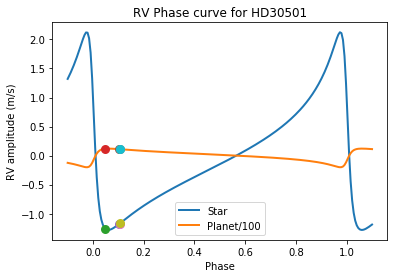

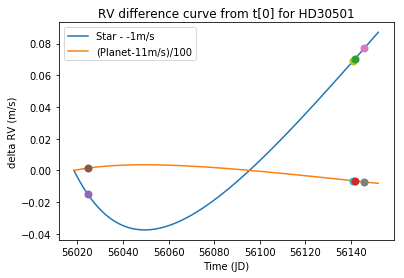


Target HD162020
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [ 0.74997337  0.70087144] m/s
RV change over exptime     = [-0.04004668 -0.03980776] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 53.83294444444444 
Gamma subtracted rv values = [-40.37327452 -37.72997313] m/s
RV change over exptime     = [ 2.15583067  2.14296914] m/s
Successive Star RV Diff - star     = [-0.04910193] m/s
Successive planet RV Diff - planet = [ 2.64330139] m/s
Band Lower wl shift - star         = [ 0.0003474] nm
Band Upper wl shift - star         = [ 0.00035381] nm
Band Lower wl shift - planet       = [ 0.01870157] nm
Band Upper wl shift - planet       = [ 0.01904675] nm


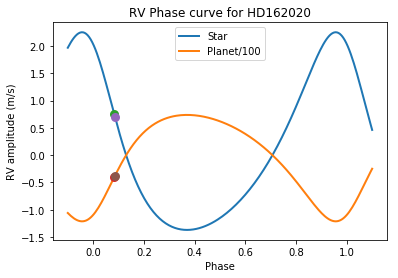

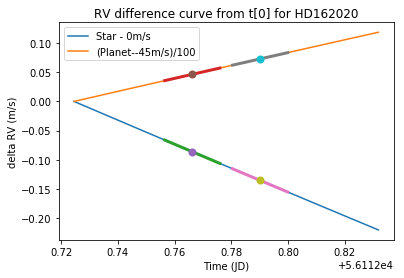


Target HD202206
Radial velocity values of the host star.
Gamma subtracted RV values for b = [-0.36145752 -0.34552461 -0.37744031] m/s
RV change over exptime for b     = [ 0.00032961  0.00032311  0.00033592] m/s
Gamma subtracted RV values for c = [ 0.04034149  0.04041541  0.04026828] m/s
RV change over exptime for c     = [  1.51932461e-06   1.50881462e-06   1.52955752e-06] m/s
Combined RV value for triplet    = [-0.32111603 -0.3051092  -0.33717204] m/s
Combined RV Diff between Obs     = [ 0.01600682 -0.03206283] m/s

Radial velocity values of the planet.
Maximum mass ratio value for b   = 11.71464946236559 
Maximum mass ratio value for c   = 64.08602352941176 
Gamma subtracted RV values for b = [ 4.23434814  4.04769974  4.42158098] m/s
RV change over exptime for b     = [-0.00386127 -0.00378513 -0.00393515] m/s
Gamma subtracted RV values for c = [-2.58532597 -2.59006294 -2.58063371] m/s
RV change over exptime for c     = [ -9.73674725e-05  -9.66939293e-05  -9.80232593e-05] m/s
Combine

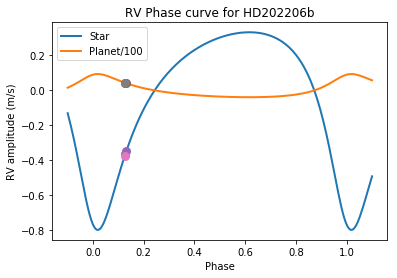

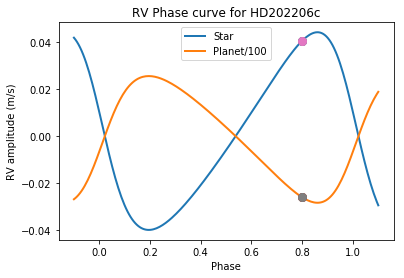

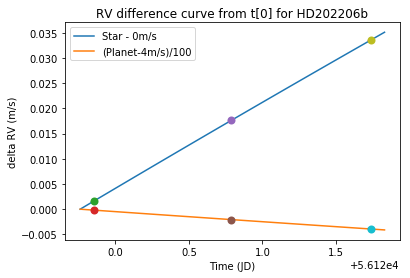

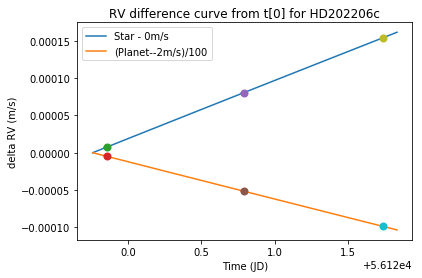


Target HD211847
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [ 0.01324057  0.01368653] m/s
RV change over exptime     = [  1.24482586e-06   1.23828876e-06] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 6.352944516129032 
Gamma subtracted rv values = [-0.08411658 -0.08694977] m/s
RV change over exptime     = [ -7.90830961e-06  -7.86677978e-06] m/s
Successive Star RV Diff - star     = [ 0.00044596] m/s
Successive planet RV Diff - planet = [-0.00283319] m/s
Band Lower wl shift - star         = [  3.15523675e-06] nm
Band Upper wl shift - star         = [  3.21347397e-06] nm
Band Lower wl shift - planet       = [  2.00450459e-05] nm
Band Upper wl shift - planet       = [  2.04150233e-05] nm


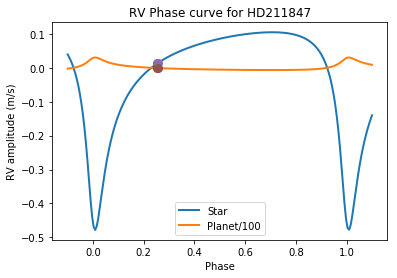

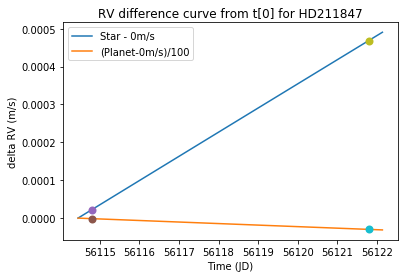


Target HD4747
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [ 0.0235157] m/s
RV change over exptime     = [ -1.51074996e-06] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 18.406151843817785 
Gamma subtracted rv values = [-0.43283348] m/s
RV change over exptime     = [  2.78070931e-05] m/s
Successive Star RV Diff - star     = [] m/s
Successive planet RV Diff - planet = [] m/s
Band Lower wl shift - star         = [] nm
Band Upper wl shift - star         = [] nm
Band Lower wl shift - planet       = [] nm
Band Upper wl shift - planet       = [] nm


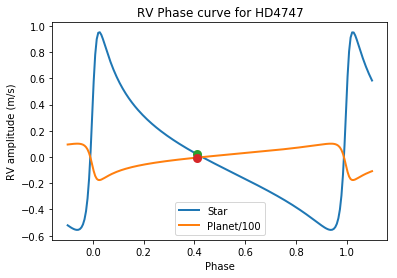

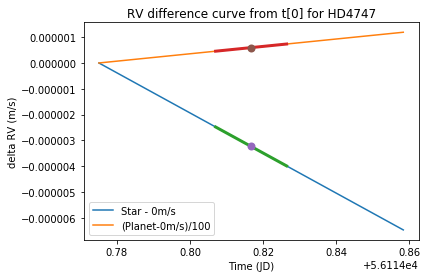


Target HD167665
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-0.42568597 -0.42570458 -0.43148997] m/s
RV change over exptime     = [ -1.42487709e-05  -1.42488705e-05  -1.42789045e-05] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 23.601154150197623 
Gamma subtracted rv values = [ 10.04668021  10.04711932  10.18366132] m/s
RV change over exptime     = [ 0.00033629  0.00033629  0.000337  ] m/s
Successive Star RV Diff - star     = [ -1.86057029e-05  -5.78539485e-03] m/s
Successive planet RV Diff - planet = [ 0.00043912  0.136542  ] m/s
Band Lower wl shift - star         = [  1.31636625e-07   4.09321392e-05] nm
Band Upper wl shift - star         = [  1.34066340e-07   4.16876364e-05] nm
Band Lower wl shift - planet       = [  3.10678161e-06   9.66045714e-04] nm
Band Upper wl shift - planet       = [  3.16412434e-06   9.83876324e-04] nm


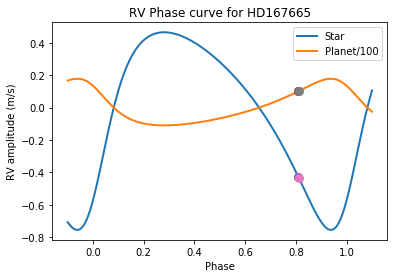

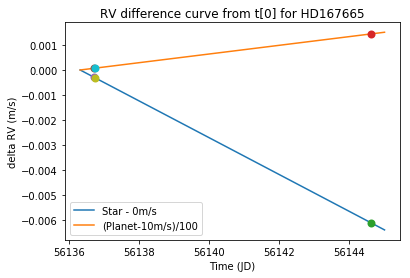


Target HD168443
Radial velocity values of the host star.
Gamma subtracted RV values for b = [ 0.07935746  0.07978653] m/s
RV change over exptime for b     = [ 0.00041052  0.00040944] m/s
Gamma subtracted RV values for c = [-0.26312545 -0.26313032] m/s
RV change over exptime for c     = [ -4.64710413e-06  -4.64554205e-06] m/s
Combined RV value for triplet    = [-0.18376799 -0.18334378] m/s
Combined RV Diff between Obs     = [ 0.00042421] m/s

Radial velocity values of the planet.
Maximum mass ratio value for b   = 136.09116072594333 
Maximum mass ratio value for c   = 60.62480079101959 
Gamma subtracted RV values for b = [-10.79984909 -10.85824194] m/s
RV change over exptime for b     = [-0.05586747 -0.05572149] m/s
Gamma subtracted RV values for c = [ 15.95192828  15.95222308] m/s
RV change over exptime for c     = [ 0.00028173  0.00028164] m/s
Combined RV value for triplet    = [ 5.15207919  5.09398114] m/s
Combined RV Diff between Obs     = [-0.05809805] m/s
Successive Star RV Diff 

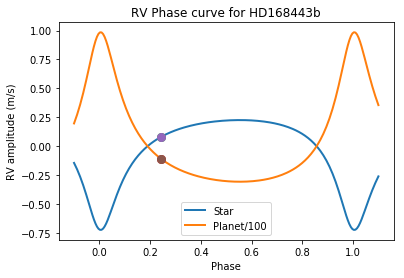

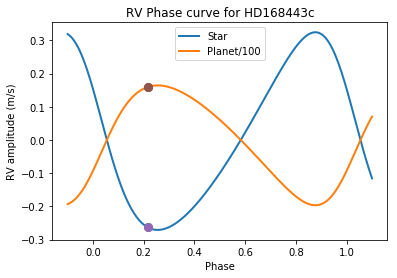

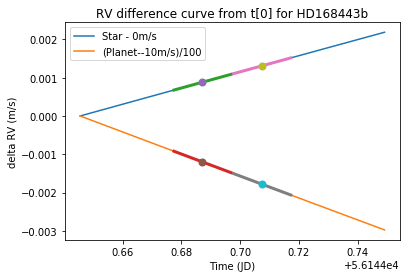

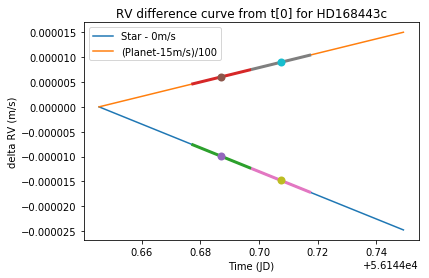

In [47]:
print("For ploting the RV curves the Planet RV has been divided by a factor of 100.")
print("When zooming up to just during the observations. The values are the difference from the RV at the start of this time space. To show the relative diferences, The planet RV is again scaled down by a factor of 100.")
print("The tick lines visible in a couple of the plots show the RV change during observation nod cycle. Only visible when observations were very close.")

results = RV_calculations(times_dict, params_dict)


From testing it appears that all the calculations for the planet RV, expected doppler shifts, RV difference between observations are all just scaled by the planet to star mass ratio m1/m2.

When only a minimum planet mass is given (m2sinI) then this corresponds to a maxmium of the mass ratio and therefore this will be a maximum expected doppler shift.



In [95]:
# Print out table for RV of the planet

print("Name: \t\t RV 1 \t\t RV 2 \t\t RV 3 \t\t RV 4")
for targ in results.keys():
    vals = list(np.round(results[targ], 3))
    #print(vals)
    for i in range(4-len(vals)):
        vals.append(np.nan)
    
    print("{0:9}\t{1: 5.4}\t\t{2: 5.4}\t\t{3: 5.4}\t\t{4: 5.4}\t ".format(targ, vals[0],vals[1],vals[2],vals[3]))
    
print("\nMaximum RV difference between all obervations of each target")
print("\nName: \t Delta RV(m/s) \t| msini(MJ) K2 Semi-Amp(m/s)  Period (days)")
Msun_Mjup = 1047.56 # Mjup
for targ in results.keys():
    vals = list(np.round(results[targ], 3))
    #print(vals)
    for i in range(4-len(vals)):
        vals.append(np.nan)
    targ_params = params_dict[targ]
    
    K2 = -targ_params[1] * Msun_Mjup * targ_params[6] / targ_params[7]
    Period  = targ_params[5]
    print("{0:9}\t{1:5} \t|{2:5}\t\t{3: 7}\t\t{4:5}".format(targ, int(max(vals*1000)-min(vals*1000)), int(targ_params[7]), int(K2*1000), int(Period)))
    

Name: 		 RV 1 		 RV 2 		 RV 3 		 RV 4
HD30501  	 11.85		 11.06		 11.05		 10.98	 
HD162020 	-40.37		-37.73		  nan		  nan	 
HD202206b	 4.234		 4.048		 4.422		  nan	 
HD202206c	-2.585		-2.59		-2.581		  nan	 
HD211847 	-0.084		-0.087		  nan		  nan	 
HD4747   	-0.433		  nan		  nan		  nan	 
HD167665 	 10.05		 10.05		 10.18		  nan	 
HD168443b	-10.8		-10.86		  nan		  nan	 
HD168443c	 15.95		 15.95		  nan		  nan	 

Maximum RV difference between all obervations of each target

Name: 	 Delta RV(m/s) 	| msini(MJ) K2 Semi-Amp(m/s)  Period (days)
HD30501  	    0 	|   90		 -16056		 2073
HD162020 	    2 	|   14		 -97599		    8
HD202206b	    0 	|   93		  -6615		  255
HD202206c	    0 	|   17		  -2692		 1383
HD211847 	    0 	|  155		  -1851		 7929
HD4747   	    0 	|   46		 -13902		13835
HD167665 	    0 	|   50		 -14384		 4451
HD168443b	    0 	|    7		 -64661		   58
HD168443c	    0 	|   17		 -18048		 1749


In [70]:
# hd30501rv = RV(*np.asarray(HD30501_params)[[]])
# hd30501rv.rv_at_times(HD30501_times)
# [mean_val, K1, omega,   e,     Tau,       Period, starmass (Msun), msini(Mjup), i]

In [104]:
import os 
for name in ["HD30501", "HD211847", "HD4747"]:
    pars = params_dict[name]
    times = times_dict[name]
    param_file_name = os.path.join("/home/jneal/Phd/data/parameter_files", "{0}_params.dat".format(name))
    time_file_name = os.path.join("/home/jneal/Phd/data/parameter_files", "{0}_obs.dat".format(name))
    parhost = RV(*np.asarray(pars)[[1, 5, 3, 4, 0, 2]], **{"m1":pars[6]*1047.56, "m2":pars[7]})
    parcomp = parhost.create_companion()
    filehost = RV.from_file(param_file_name)
    filehost._params["m1"] = filehost._params["m_star"] * 1047.56
    filehost._params["m2"] = filehost._params.get("m_true", filehost._params.get("msini"))
    filecomp = filehost.create_companion()
    #print(parcomp)
    #print(filecomp)
    #assert filecomp == parcomp
    parrv = parcomp.rv_at_times(np.asarray(times))
    filerv = filecomp.rv_at_times(np.asarray(times))
    RV_diff_par = max(parrv) - min(parrv)
    print(name, "RV difference")
    print(RV_diff_par)
    RV_diff_file = max(filerv) - min(filerv)
    print(RV_diff_file)
    print()
    

HD30501 RV difference
1.34048504145
1.34048504145

HD211847 RV difference
0.00387779269167
0.00387779269167

HD4747 RV difference
0.0
0.0



In [ ]:
RV?